## Smart Instant Pot Detection Notebook
This Jupyter notebook is used to experiment with feature matching and text recognition for the smart instant pot project.

Useful links:
-   [OpenCV Python tutorial on feature matching & homography](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html)
-   [Image Alignment (Feature Based) using OpenCV](https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/)
-   [Recognizing Digits with OpenCV and Python](https://www.pyimagesearch.com/2017/02/13/recognizing-digits-with-opencv-and-python/)
-   [OpenCV Text Scene Detection and Recognition](https://docs.opencv.org/3.0-beta/modules/text/doc/text.html)

In [1]:
# Import matplotlib and OpenCV
from matplotlib import pyplot as plt
import numpy as np
import cv2

In [2]:
# Function to simplify showing an OpenCV image.
def plot_image(img, title=None):
    # Assume color images are BGR and must be converted to RGB for plotting.
    # Otherwise it must be grayscale and can plot directly.
    if len(img.shape) > 2:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.show()

## Control panel detection experiments

In [4]:
# Load images and convert to grayscale.
test_img = cv2.resize(cv2.imread('../test_images/test.jpg'), (0, 0), fx=0.25, fy=0.25)
panel_img = cv2.imread('../test_images/control_panel.jpg')

test_img_gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
panel_img_gray = cv2.cvtColor(panel_img, cv2.COLOR_BGR2GRAY)

In [5]:
# Detect ORB features and compute descriptors.
#orb = cv2.ORB_create(MAX_FEATURES)
#keypoints1, descriptors1 = orb.detectAndCompute(test_img_gray, None)
#keypoints2, descriptors2 = orb.detectAndCompute(panel_img_gray, None)

# Detect SIFT features.
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
keypoints1, descriptors1 = sift.detectAndCompute(test_img_gray, None)
keypoints2, descriptors2 = sift.detectAndCompute(panel_img_gray, None)

In [6]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors1,descriptors2,k=2)

# Ratio test to keep good matches.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
print(f'Found {len(good)} matches.')

Found 73 matches.


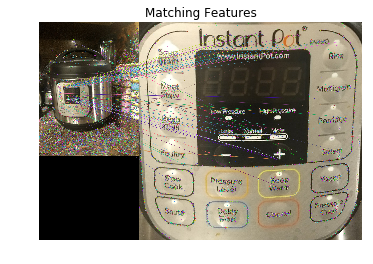

In [7]:
# Draw top matches
plot_image(cv2.drawMatches(test_img, keypoints1, panel_img, keypoints2, good, None), 'Matching Features')

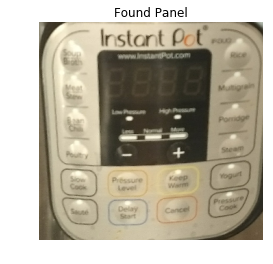

In [8]:
# Extract location of good matches
points1 = np.zeros((len(good), 2), dtype=np.float32)
points2 = np.zeros((len(good), 2), dtype=np.float32)
 
for i, match in enumerate(good):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

# Find homography
h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
 
# Use homography
height, width, channels = panel_img.shape
translated = cv2.warpPerspective(test_img, h, (width, height))
plot_image(translated, 'Found Panel')

## Digit detection & recognition experiments

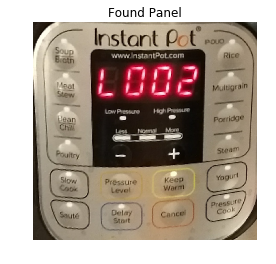

In [280]:
import cv2
import smart_instant_pot.detector as detector
panel = cv2.imread('../test_images/control_panel.jpg')
d = detector.Detector(panel)
#result = d.detect_panel(cv2.imread('../test_images/cook-30-01.jpg'))
result = d.detect_panel(cv2.imread('../test_images/l-02-01.jpg'))
if result is None:
    print('Failed to find Instant Pot in input image!')
else:
    plot_image(result, 'Found Panel')

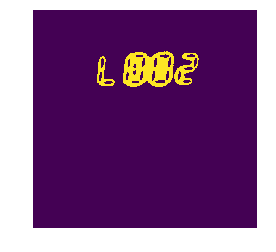

In [281]:
# Convert to HSV color space and apply threshold to find bright red digits.
result_hsv = cv2.cvtColor(result, cv2.COLOR_BGR2HSV)
lower_red = np.array([160, 125, 125])
upper_red = np.array([180, 255, 255])
threshold = cv2.inRange(result_hsv, lower_red, upper_red)
plot_image(threshold)

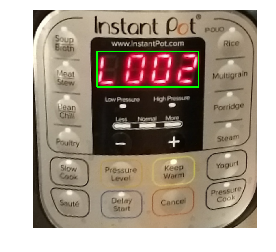

In [282]:
# Find contour to bound entire region.
contour = threshold.copy()
_, contours, hierarchy = cv2.findContours(contour, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Find the min and max x,y points of the rectangle to bound all the contours.
x0,y0,w,h = cv2.boundingRect(contours[0])
x1 = x0+w
y1 = y0+h
for i in range(1, len(contours)):
    x, y, w, h = cv2.boundingRect(contours[i])
    x0 = min(x, x0)
    y0 = min(y, y0)
    x11 = x+w
    y11 = y+h
    x1 = max(x11, x1)
    y1 = max(y11, y1)
plot_image(cv2.rectangle(result.copy(),(x0,y0),(x1,y1),(0,255,0),5))

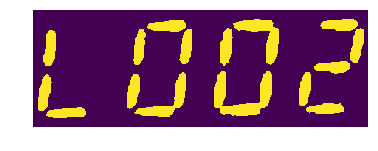

In [283]:
# Grab LCD region, grayscale and threshold it (using otsu bimodal threshold).
lcd = result[y0:y1, x0:x1]
#_, lcd_threshold = cv2.threshold(cv2.cvtColor(lcd, cv2.COLOR_BGR2GRAY), 70, 255, cv2.THRESH_BINARY)
_, lcd_threshold = cv2.threshold(cv2.cvtColor(lcd, cv2.COLOR_BGR2GRAY), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plot_image(lcd_threshold)

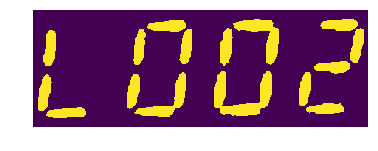

In [284]:
# Throw out square contours to get rid of colon dots?
# Then dilate to fill in gaps, extract contours and do 7 segment detect?
no_colon = lcd_threshold.copy()
height, width = no_colon.shape
_, contours, hierarchy = cv2.findContours(no_colon, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Throw out any small square contours near the center to get rid of the colon dots.
for c in contours:
    x,y,w,h = cv2.boundingRect(c)
    aspect = w/h
    if abs(aspect-1.0) <= 0.1 and abs(x-width/2) <= 20:
        cv2.rectangle(no_colon, (x, y), (x+w, y+h), 0, cv2.FILLED)
plot_image(no_colon)

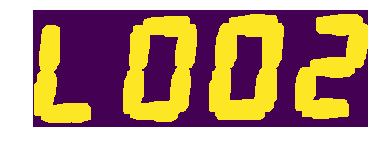

In [285]:
# Dilate to fill in gaps between segments.
dilate_kernel = np.ones((13,13),np.uint8)
dilation = cv2.dilate(no_colon, dilate_kernel, iterations = 1)
plot_image(dilation)

Contour 0: (1, 20) - 0.5833333333333334
Contour 1: (122, 8) - 0.6993006993006993
Contour 2: (355, 6) - 0.7021276595744681
Contour 3: (239, 6) - 0.7062937062937062


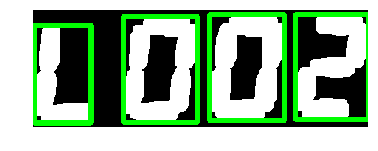

In [286]:
# Find and plot countour bounding boxes.
# Find contour to bound entire region.
digit_contours = dilation.copy()
_, contours, hierarchy = cv2.findContours(digit_contours, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Highlight bounding rect of all the contours.
digit_contour_img = cv2.cvtColor(dilation, cv2.COLOR_GRAY2BGR)
for i, c in enumerate(contours):
    x0,y0,w,h = cv2.boundingRect(c)
    cv2.rectangle(digit_contour_img, (x0, y0), (x0+w, y0+h), (0, 255, 0), 5)
    aspect = w/h
    print(f'Contour {i}: ({x0}, {y0}) - {aspect}')
plot_image(digit_contour_img)

In [287]:
# Do digit detection.
digit_segments = {
    (True, True, True, False, True, True, True): '0',
    (False, False, True, False, False, False, True): '1',
    (False, True, True, True, True, True, False): '2',
    (False, True, True, True, False, True, True): '3',
    (True, False, True, True, False, False, True): '4',
    (True, True, False, True, False, True, True): '5',
    (True, True, False, True, True, True, True): '6',
    (False, True, True, False, False, False, True): '7',
    (True, True, True, True, True, True, True): '8',
    (True, True, True, True, False, False, False): '9',
    (True, False, False, False, True, True, False): 'L',
}


def detect_digit(img):
    height, width = img.shape
    aspect = width / height
    area = height * width
    # Handle a 1 as a special case with a very tall aspect ratio and mostly turned on pixels.
    if abs(aspect - 0.1) <= 0.1 and cv2.countNonZero(img) >= (0.8 * area):
        return [False, False, True, False, False, False, True]
    # Otherwise check each of the segment locations.
    seg_size = int(width/3)
    vmid = int(height/2)
    d0 = ((0, 0), (seg_size, vmid))                                 # Upper left
    d1 = ((seg_size, 0), (width-1-seg_size, seg_size))              # Top
    d2 = ((width-1-seg_size, 0), (width-1, vmid))                   # Upper right
    d3 = ((seg_size, vmid-(seg_size//2)), (width-1-seg_size, vmid+((seg_size//2)))) # Middle
    d4 = ((0, vmid), (seg_size, height-1))                          # Lower left
    d5 = ((seg_size, height-1-seg_size), (width-1-seg_size, height-1))              # Bottom
    d6 = ((width-1-seg_size, vmid), (width-1, height-1))            # Lower right
    segments = []
    for d in (d0, d1, d2, d3, d4, d5, d6):
        p1, p2 = d
        x0, y0 = p1
        x1, y1 = p2
        area = (x1-x0)*(y1-y0)
        pixels = img[y0:y1, x0:x1]
        if cv2.countNonZero(pixels) / area >= 0.50:
            segments.append(True)
        else:
            segments.append(False)
    return segments

# Sort contours by ascending x position (left to right order).
digits = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    digits.append(((x, y), (x+w, y+h)))
digits.sort(key=lambda x: x[0][0])
for i, d in enumerate(digits):
    p1, p2 = d
    d0, d1, d2, d3, d4, d5, d6 = detect_digit(dilation[p1[1]:p2[1], p1[0]:p2[0]])
    val = digit_segments.get((d0, d1, d2, d3, d4, d5, d6), '?')
    print(f'Digit {i}: {val}')
        

Digit 0: L
Digit 1: 0
Digit 2: 0
Digit 3: 2


In [213]:
# Another option to try OCR--this turns out to not work very well with LED digits.
# Save to temp file for OCR.
cv2.imwrite('temp.png', cv2.bitwise_not(dilation))
import pytesseract
from PIL import Image
#text = pytesseract.image_to_string(Image.open('temp.png'))
#text = pytesseract.image_to_string(Image.open('temp.png'), lang="letsgodigital", config="-psm 7 -c tessedit_char_whitelist=0123456789")
text = pytesseract.image_to_string(Image.open('temp.png'), lang="eng", config="-psm 7 -c tessedit_char_whitelist=:0123456789")
print(f'Found text: {text}')

Found text: 83:33
